# Set-up
## Module imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Getting data

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Data coverage and description

First, look at the columns, data types and null values.

In [3]:
d = train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null object
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.6+ KB


As expected, neither casual, registered not count features in the test dataset! It seems that there aren't any null objects in either dataset - we'll have to see if this really means that the data is complete.
## Temporal data
Let's first look at categorical data.

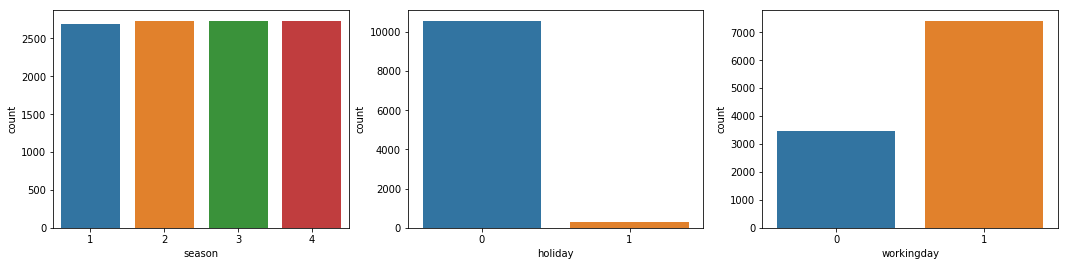

In [5]:
plot, axes = plt.subplots(1, 3, figsize=(18, 4))

for index, column in enumerate(['season', 'holiday', 'workingday']):
    sns.countplot(train[column], ax=axes[index])

Time-related data does indeed seem complete. The data is balanced over the seasons, as expected. It's a little short in season 1. This must be because months are shorter in this period. It's also worth noting that holiday data is fairly sparse.

Let's now inspect the time stamps. We will need to know if these are *times* or *datetimes* - see how many unique values there are to start this investigation.

In [6]:
len(train['datetime'].unique())

10886

So - we have one unique value for each row. We will need to convert this into a time-of-day metric for it to be of any use. Let's look at the format of the first datetime.

In [7]:
first_date = train['datetime'][0]
first_date

'2011-01-01 00:00:00'

In [8]:
from datetime import datetime

def parse_datetime(dt):
    return datetime.strptime(dt, '%Y-%m-%d %H:%M:%S')

parse_datetime(first_date)

datetime.datetime(2011, 1, 1, 0, 0)

This works fine. Let's convert the datetime column into datetime objects.

In [9]:
datetimes = train['datetime'].apply(parse_datetime)
datetimes.head()

0   2011-01-01 00:00:00
1   2011-01-01 01:00:00
2   2011-01-01 02:00:00
3   2011-01-01 03:00:00
4   2011-01-01 04:00:00
Name: datetime, dtype: datetime64[ns]

Let's check that the data don't contain any funny entries, i.e. where the minute or second are non-zero.

In [10]:
minutes = datetimes.apply(lambda dt: dt.minute)
seconds = datetimes.apply(lambda dt: dt.second)

minutes.unique(), seconds.unique()

(array([0]), array([0]))

Perfect! Now we need to map datetimes to time of day.

In [11]:
train['hour'] = datetimes.apply(lambda dt: dt.hour)
train['hour'].head()

0    0
1    1
2    2
3    3
4    4
Name: hour, dtype: int64

Let's take a quick look at the distribution.

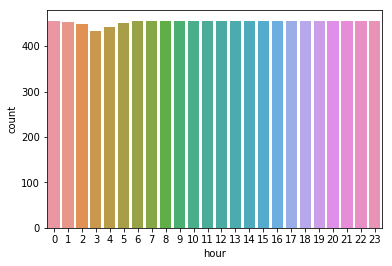

In [12]:
sns.countplot(train['hour'])

First, we should note that there aren't any null or silly values. Secondly, we have slightly less data for early hours in the morning - presumably this is around the time that the train-test data cutoff occurs each month? Let's also look at distribution of data across years.

In [27]:
datetimes.apply(lambda dt: dt.year).value_counts()

2012    5464
2011    5422
Name: datetime, dtype: int64

## Environmental data
Some of the environmental data contain quite a lot of values. Some of them are expressed as floating point numbers. Let's get unique value counts before plotting anything.

In [13]:
env = 'weather', 'temp', 'atemp', 'humidity', 'windspeed'

pd.Series({ e: len(train[e].unique()) for e in env })

atemp        60
humidity     89
temp         49
weather       4
windspeed    28
dtype: int64

So - there are quite a number of unique values for each column, barring weather, there is less variation than you might expect. Lets have a look at these data.

In [14]:
train.loc[:, env].sample(n=10)

,weather,temp,atemp,humidity,windspeed
5476,1,5.74,6.060,59,16.9979
2656,2,32.80,36.365,46,19.0012
10184,1,17.22,21.210,44,7.0015
2275,1,31.16,32.575,20,35.0008
1230,3,12.30,13.635,100,19.9995
797,1,18.86,22.725,31,26.0027
6122,3,9.02,11.365,93,8.9981
9304,1,20.50,24.240,63,0.0000
1994,1,19.68,23.485,63,0.0000
747,1,22.96,26.515,22,30.0026


Floating point values seem to occur at a fixed series of fairly random-looking values. Let's see if these are linearly distributed.

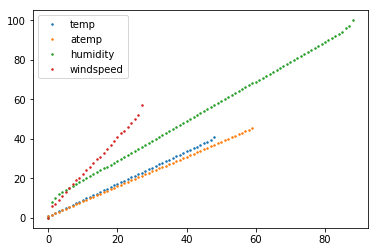

In [15]:
multivalued = list(filter(lambda e: e != 'weather', env))

for col in multivalued:
    uniques = train[col].unique()
    plt.plot(
        range(len(uniques)), 
        sorted(uniques), 
        label=col, 
        marker='.', 
        markersize=3,
        linestyle=''
    )
    
plt.legend()

So - nearly linear, but not exactly so. This is a little curious but not really an issue! Finally, let's look at the distributions.

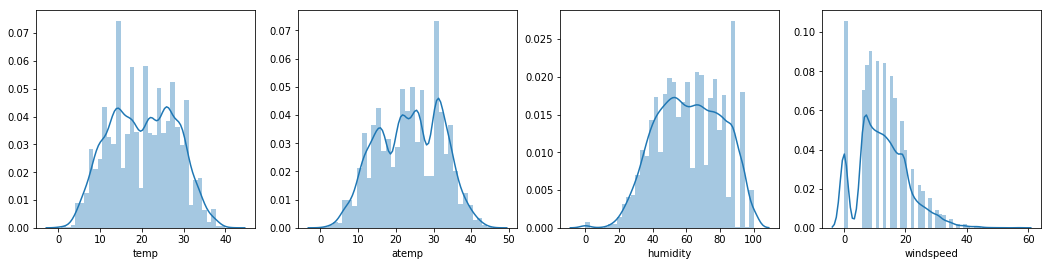

In [16]:
plot, axes = plt.subplots(1, 4, figsize=(18, 4))

for index, column in enumerate(multivalued):
    sns.distplot(train[column], ax=axes[index])

They all seem fairly well-distributed other than windspeed, which is fairly skewed.

In [17]:
train.loc[:, multivalued].describe()

,temp,atemp,humidity,windspeed
count,10886.00000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395
std,7.79159,8.474601,19.245033,8.164537
min,0.82000,0.760000,0.000000,0.000000
25%,13.94000,16.665000,47.000000,7.001500
50%,20.50000,24.240000,62.000000,12.998000
75%,26.24000,31.060000,77.000000,16.997900
max,41.00000,45.455000,100.000000,56.996900


**Perhaps some more comments on these metrics?**

Now on to weather.

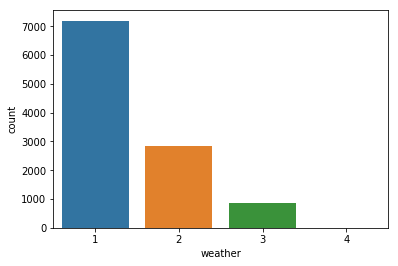

In [33]:
sns.countplot(train['weather'])

Interestingly, there is a fourth category that seems to have a very small number of values.

In [34]:
train['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

It is likely that this fourth category will have to be imputed away.

## Rentals
Finally, let's look at rental counts. First, a quick sanity check.

In [23]:
(train['count'] == train['registered'] + train['casual']).all()

True

Registered and casual data do indeed sum to the count on any given day. Let's have a quick look at some summary statistics.

In [18]:
counts = 'count', 'registered', 'casual'
train.loc[:, counts].describe()

,count,registered,casual
count,10886.000000,10886.000000,10886.000000
mean,191.574132,155.552177,36.021955
std,181.144454,151.039033,49.960477
min,1.000000,0.000000,0.000000
25%,42.000000,36.000000,4.000000
50%,145.000000,118.000000,17.000000
75%,284.000000,222.000000,49.000000
max,977.000000,886.000000,367.000000


We can put together a rudimentary time-series - ignore the funny lines joining disjointed time periods!

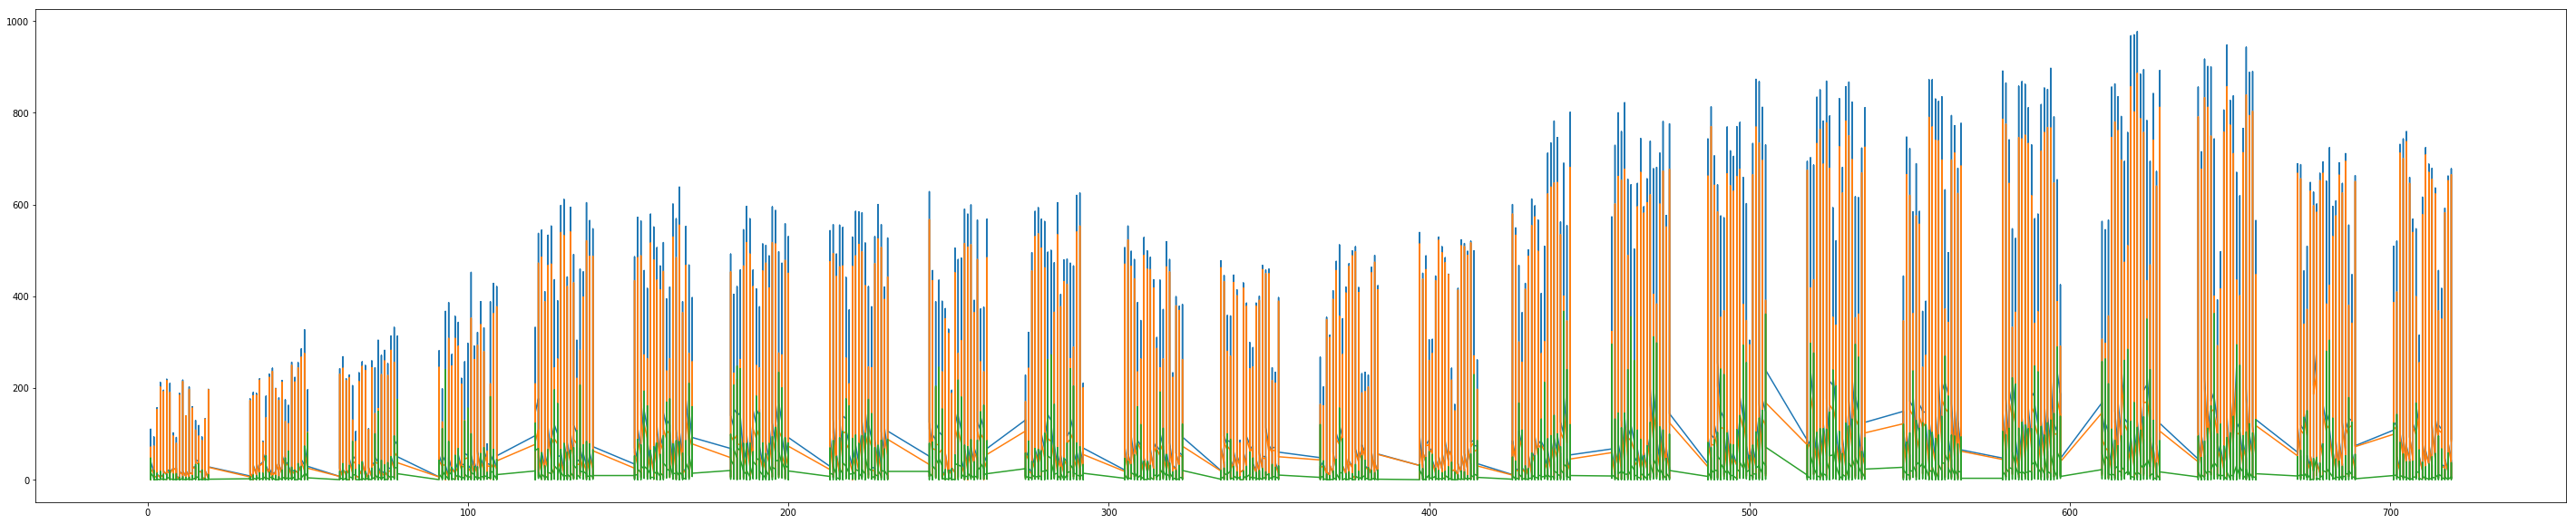

In [31]:
train['day'] = datetimes.apply(lambda dt: dt.timetuple().tm_yday + (365 * (dt.year == 2012)))

plt.figure(figsize=(50, 10))

plt.plot(train['day'], train['count'])
plt.plot(train['day'], train['registered'])
plt.plot(train['day'], train['casual'])

Interestingly, there seems to be a long-term increase in rentals as time goes on. This is presumably something to factor into the analysis - it seems like the year is something that will affect the outcome!

# Relationships